#  Libraries and setup

In [1]:
import matplotlib
import seaborn
import pdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import matplotlib.gridspec as gridspec
import decimal
import random
from scipy import interpolate

#ploting appearance 
seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'font.weight': 'bold'})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'axes.titlesize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'legend.fontsize': 20})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})
matplotlib.rcParams.update({'axes.titleweight': 'bold'})
matplotlib.rcParams.update({'mathtext.default':'regular'})

%matplotlib inline

# Functions

In [2]:
def make_tij(af,genes):
    '''gene expression matrix equation 11 in Jeremies pdf'''
    tij = pd.DataFrame(1, index=genes.index, columns=af.index)
    tij = tij.multiply(genes['km'], axis='index') / af[0]
    tij = 1.0/(1.0+ tij)
    tij = 1+ tij.multiply((genes['t0']/genes['tinf'] -1), axis='index')
    tij = 1.0/tij
    tij= tij.multiply(genes['t0'], axis='index')
    return tij

def return_tij_trans(tij,genes):
    '''Get left side of equation 12 from tij'''
    up=genes['t0']/genes['tinf'] -1
    tij_transformed=tij.copy()
    for a in tij.columns:
            tij_transformed[a]=(up/(genes['t0']/tij[a] -1) -1)
    return tij_transformed

def calc_km_af(tij,genes):
    '''Equations 13-16'''
    tij_transformed=return_tij_trans(tij,genes)
    u,s,v=np.linalg.svd(tij_transformed)
    af_out=1.0/(-1.0*np.sqrt(s[0])*v[0])
    km_out=-1.0*np.sqrt(s[0])*u.T[0]
    return pd.DataFrame(km_out, index=genes.index),\
           pd.DataFrame(af_out, index=tij.columns)

def calc_At(tij,genes,af):
    At = pd.DataFrame(1.0, index=genes.index, columns=af.index)
    At = At.multiply(genes['km'], axis='index')/af[0]
    At = 1.0/(1.0 + At)
    At = At*tij
    At = At.sum()
    At = At+ af[0]
    return At

def calc_af(af,genes,At, name='cell_1'):
    '''Calculate free miRNA levels af from total, equation 20-21'''
    f=pd.DataFrame(genes['km']/af)
    af=pd.DataFrame([af], index=[name])
    tij_out=make_tij(af,genes)
    
    f.columns=af.index
    f=1.0/(1.0+f)
    At_out=af + pd.DataFrame((f*tij_out).sum())
    difference_A= np.abs(At - At_out)
    return difference_A[0][0]


# Simple model - paramters generation

In [3]:
#genes transcription
genes=pd.DataFrame(np.random.lognormal(2,0.6,300))
genes.columns=['alpha']
####################

#genes decay; and decay when bound by the miRNA
genes['d']=pd.DataFrame(np.random.lognormal(-2.,0.1,300))
genes['d_delta']=genes['d']+genes['d']*np.random.exponential(0.1,300)+0.01
####################

#genes binding and unbinding constants of targets
genes['k_off']=pd.DataFrame(np.random.lognormal(0.5,3.0,300))*0.1
genes['k_on']=np.random.lognormal(0,7.2,300)
####################

#Michalis-Menten constant
genes['km']=(genes['k_off']+genes['d_delta'])/genes['k_on']
####################

#gene levels with no miRNA and with full miRNA saturation; fold change and free ago critical level
genes['t0']=genes['alpha']/genes['d']
genes['tinf']=genes['alpha']/genes['d_delta']
genes['fc']=genes['t0']/genes['tinf']
genes['fac']=genes['km']/genes['fc']
####################

#free miRNA numbers in a cell -- this is how miRNA range is created; total miRNA and target levels are calculated
#from the af values
af_log=[random.uniform(-40,14) for i in range(4000)]
af=2**np.array(af_log)
#lets make it unique
af=np.unique(af)
#sort what is left
af=pd.DataFrame(np.sort(af), index=('cell_'+pd.DataFrame(np.arange(len(af)).astype(str))).values.T[0])
####################

#lets make tij array
tij=make_tij(af,genes)
####################

#info
print 'Number of cells:',len(af), "Number of genes and cells", tij.shape
print 'median k_cut:', genes['d_delta'].median()
print 'median decay:', genes['d'].median()
print 'median k_on:', genes['k_on'].median()
print 'median k_off:', genes['k_off'].median()

Number of cells: 4000 Number of genes and cells (300, 4000)
median k_cut: 0.155780149614
median decay: 0.134677272164
median k_on: 1.19351343867
median k_off: 0.102258255078


In [4]:
#calculate total miRNA in cells from tij (target expression) and free ago levels
miRNA_tot=calc_At(tij,genes,af)

#fix low level miRNA number cells to miRNA=1
#WHATCH OUT! transformation below affects plotting of the last panel
print len(miRNA_tot[np.log2(miRNA_tot) < 1])
miRNA_tot[np.log2(miRNA_tot) < 1]=1

384


In [5]:
genes.corr()

,alpha,d,d_delta,k_off,k_on,km,t0,tinf,fc,fac
alpha,1.000000,0.098648,0.025309,-0.008380,-0.035724,-0.004407,0.980447,0.979234,-0.077994,0.004193
d,0.098648,1.000000,0.785463,-0.015744,-0.021717,-0.058126,-0.068087,-0.051511,-0.060022,-0.054411
d_delta,0.025309,0.785463,1.000000,-0.051339,-0.024559,0.010095,-0.098057,-0.138026,0.567683,-0.008173
k_off,-0.008380,-0.015744,-0.051339,1.000000,-0.004452,-0.006724,-0.007107,0.000926,-0.063132,-0.007596
k_on,-0.035724,-0.021717,-0.024559,-0.004452,1.000000,-0.006824,-0.034060,-0.033191,-0.011796,-0.006764
km,-0.004407,-0.058126,0.010095,-0.006724,-0.006824,1.000000,0.004739,0.004274,0.106293,0.987924
t0,0.980447,-0.068087,-0.098057,-0.007107,-0.034060,0.004739,1.000000,0.994088,-0.057559,0.013669
tinf,0.979234,-0.051511,-0.138026,0.000926,-0.033191,0.004274,0.994088,1.000000,-0.145471,0.015413
fc,-0.077994,-0.060022,0.567683,-0.063132,-0.011796,0.106293,-0.057559,-0.145471,1.000000,0.067448
fac,0.004193,-0.054411,-0.008173,-0.007596,-0.006764,0.987924,0.013669,0.015413,0.067448,1.000000


## Plotting parameters distributions

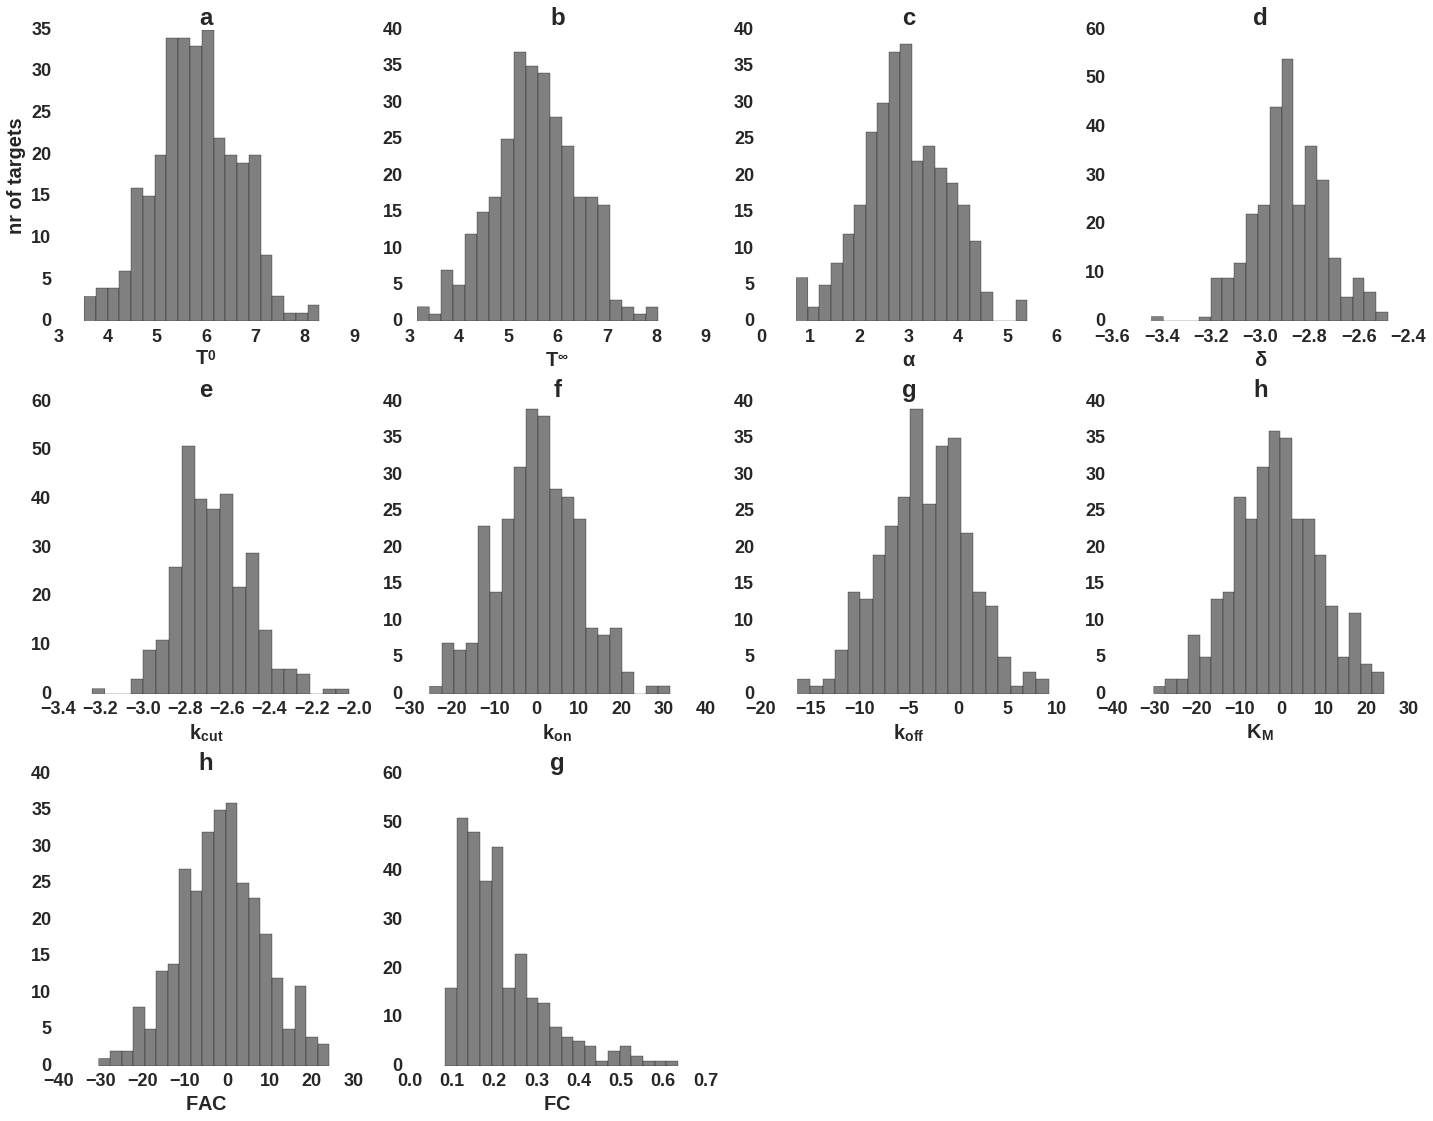

In [6]:
#######################
fig = plt.figure(figsize=(20,15), dpi=200)
gs = gridspec.GridSpec(3, 4)


#####
ax1 = plt.subplot(gs[0, 0])
#clean_axis(ax1)
_=plt.hist(np.log2(genes['t0']),20, color='grey')
plt.xlabel(r'$T^0$')
plt.ylabel('nr of targets')
plt.title('a')

####
ax = plt.subplot(gs[0, 1])
_=plt.hist(np.log2(genes['tinf']),20, color='grey')
plt.xlabel(r'$T^{\infty}$')
#plt.ylabel('nr of targets')
plt.title('b')

####
ax = plt.subplot(gs[0, 2])
_=plt.hist(np.log2(genes['alpha']),20, color='grey')
plt.xlabel(r'$\alpha$')
#plt.ylabel('nr of targets')
plt.title('c')

####
ax = plt.subplot(gs[0, 3])
_=plt.hist(np.log2(genes['d']),20, color='grey')
plt.xlabel(r'$\delta$')
#plt.ylabel('nr of targets')
plt.title('d')

####
ax = plt.subplot(gs[1, 0])
_=plt.hist(np.log2(genes['d_delta']),20, color='grey')
plt.xlabel(r'$k_{cut}$')
#plt.ylabel('nr of targets')
plt.title('e')

####
ax = plt.subplot(gs[1, 1])
_=plt.hist(np.log2(genes['k_on']),20, color='grey')
plt.xlabel(r'$k_{on}$')
#plt.ylabel('nr of targets') 
plt.title('f')

####
ax = plt.subplot(gs[1, 2])
_=plt.hist(np.log2(genes['k_off']),20, color='grey')
plt.xlabel(r'$k_{off}$')
#plt.ylabel('nr of targets') 
plt.title('g')

####
ax = plt.subplot(gs[1, 3])
_=plt.hist(np.log2(genes['km']),20, color='grey')
plt.xlabel(r'$K_{M}$')
#plt.ylabel('nr of targets')
plt.title('h')
plt.tight_layout()

ax = plt.subplot(gs[2, 0])
_=plt.hist(np.log2(genes['km']/(genes['t0']/genes['tinf'])),20, color='grey')
plt.xlabel(r'$FAC$')
#plt.ylabel('nr of targets')
plt.title('h')
#plt.tight_layout()

ax = plt.subplot(gs[2, 1])
_=plt.hist(np.log2(genes['t0']/genes['tinf']),20, color='grey')
plt.xlabel(r'$FC$')
#plt.ylabel('nr of targets') 
plt.title('g')


## Gene expression in the cells and downregulation

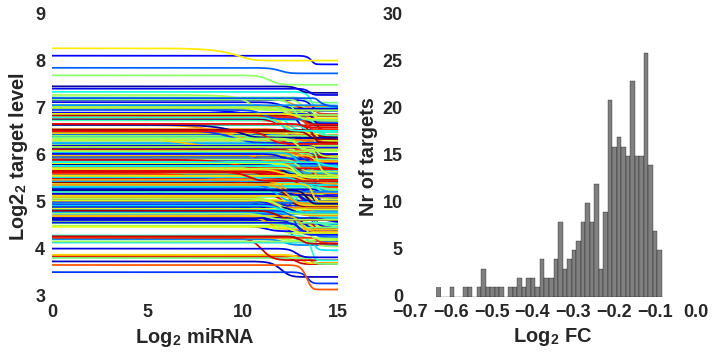

In [7]:
import pylab
def targets_levels():
    plt.locator_params(nbins=7)
    for i in tij.index:
        plt.plot(np.log2(miRNA_tot),np.log2(tij.ix[i]),c=pylab.cm.jet(np.random.random()))
    plt.xlabel(r'$Log_2$ miRNA')
    plt.ylabel(r'$Log2_2$ target level')

def plot_downregulation():
    _=plt.hist(np.log2(genes['tinf']/genes['t0']), 50, color='grey')
    plt.xlabel(r'$Log_2$ FC')
    plt.ylabel('Nr of targets')
    
    
fig = plt.figure(figsize=(10,5), dpi=200)
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0, 0])
targets_levels()
#plt.xlim([-2,16])
plt.tight_layout()

ax = plt.subplot(gs[0, 1])

plot_downregulation()
#plt.xlim([-2,16])
plt.tight_layout()


# Additional ceRNA gene and its effect on target levels

In [8]:
new_gene=genes.ix[80].copy()

In [9]:
#set parameters for 3 genes
new_gene=genes.ix[80].copy()

alpha1=40
alpha2=100
alpha3=600

km1=0.0000001
km2=0.00002
km3=5

kms=[km1,km2,km3,km1,km2,km3]
alphas=[alpha1,alpha2,alpha3]

new_gene[['alpha', 'd', 'd_delta', 'k_off', 'k_on', 'km', 't0', 'tinf', 'fc', 'fac']]= \
    [alpha1,0.1,0.15,0.0001,0.2,km1,alpha1/0.1,alpha1/0.11, 0.11/0.1, km1/(0.11/0.1) ]

new_gene=pd.DataFrame(new_gene)
new_gene.columns=[len(genes)+1] #this is after the last gene

In [10]:
#new_gene.head(10)

### The average response to ceRNA will depend on how many and what kind of genes are selected, below see number of genes with given FAC 

In [11]:
print len(genes[genes['fac'] < 0.0001].index)
print len(genes[genes['fac'] > 1].index)

37
134


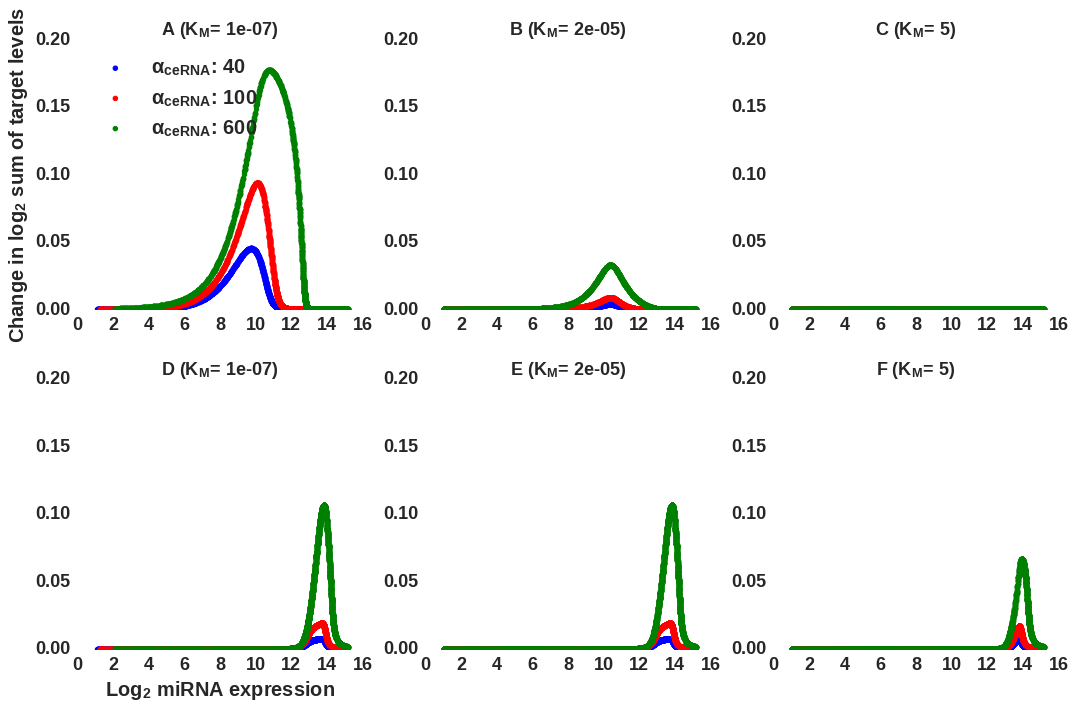

In [12]:
low_fac=0.000001 #row 1 genes
high_fac=0.1
t0cells=len(miRNA_tot[miRNA_tot <= 1]) #for the interpolate package I have to exclude cells with too many similar values, above I actually fix this cells to zero 

fig = plt.figure(figsize=(15,10), dpi=200)

#spline representation to substract on standarized x (i.e. to have the same x values (recalculated total miRNA levels))

#this is for row 1, low fac genes
expr_sums_normal_low=pd.DataFrame(tij.ix[genes[genes['fac'] < low_fac].index].sum())
expr_sums_normal_low.columns=[1]
spline_normal_low=interpolate.splrep(np.log2(miRNA_tot[t0cells:]),np.log2(expr_sums_normal_low[1][t0cells:]),s=0)

#row 2, high fac genes
expr_sums_normal_high=pd.DataFrame(tij.ix[genes[genes['fac'] > high_fac].index].sum())
expr_sums_normal_high.columns=[1]
spline_normal_high=interpolate.splrep(np.log2(miRNA_tot[t0cells:]),np.log2(expr_sums_normal_high[1][t0cells:]),s=0)

colors=['blue','red','green']
tit_let=['A','B','C','D','E','F']

for b,i in enumerate(kms):
    ax1 = plt.subplot(2,3,b+1) #plt.subplot(gs[0, b])
    for a,j in enumerate(alphas):
        #set cerna gene
        new_gene.ix['alpha']= j
        new_gene.ix['km']= i
        new_gene.ix['t0']= j/0.1
        new_gene.ix['tinf']= j/0.11
        new_gene.ix['fc']= new_gene.ix['t0']/new_gene.ix['tinf']
        new_gene.ix['fc']=new_gene.ix['km']/new_gene.ix['fc']
        
        #add new_gene to other genes
        genes_supergene=genes.append(new_gene.T)
        tij_supergene=make_tij(af,genes_supergene)
        
        #select genes for according to fac (or km) for summation and plotting; I select without the ceRNA 
        if b < 3:
            expr_sums=pd.DataFrame(tij_supergene.ix[genes[genes['fac'] < low_fac].index].sum())
            expr_sums.columns=[1]
            #recalculate total miRNA levels
            miRNA_tot_sup=calc_At(tij_supergene,genes_supergene,af)
            #plot
            plt.scatter(np.log2(miRNA_tot_sup[t0cells:]), np.log2(expr_sums[1][t0cells:]).values - \
                interpolate.splev(np.log2(miRNA_tot_sup[t0cells:]), spline_normal_low,der=0), label=r'$\alpha_{ceRNA}$: '+str(j), color=colors[a], lw=1)
        else:
            expr_sums=pd.DataFrame(tij_supergene.ix[genes[genes['fac'] > high_fac].index].sum())
            expr_sums.columns=[1]
            #recalculate total miRNA levels
            miRNA_tot_sup=calc_At(tij_supergene,genes_supergene,af)
            #plot
            plt.scatter(np.log2(miRNA_tot_sup[t0cells:]), np.log2(expr_sums[1][t0cells:]).values -\
                    interpolate.splev(np.log2(miRNA_tot_sup[t0cells:]), spline_normal_high,der=0), label=r'$\alpha_{ceRNA}$: '+str(j), color=colors[a], lw=1)

        plt.title(tit_let[b]+r' ($K_M$= ' + str(i) +')', size=18)
        plt.ylim([0,0.2])
        
    if b ==0 :
        plt.ylabel('Change in $log_2$ sum of target levels')
        plt.legend(loc=2)
    if b == 3 :    
        plt.xlabel(r'$Log_2$ miRNA expression')

plt.tight_layout()
#plt.savefig(figurepath+'/Figure_S9_Zavolan.png',dpi=100, format='png')